  # Autoencoder - Baseline mode - Copy 1

# Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
import shutil
import getpass
import yaml

from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "Autoencoder_dev.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import wandb
from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace 
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary, define_autoencoder_model
from snnl.utils import save_checkpoint_v2, load_checkpoint_v2

from snnl.models import Model
from snnl.models import DNN 
from snnl.models import Autoencoder
from snnl.losses import SNNLoss

['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages']
2.2.1+cu118


In [11]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print('Timestamp: ',timestamp)

logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
# logger.info(f" Search path      : {sys.path}")


2024-06-15 07:00:47,421 - __main__ - INFO: -  Excution started : 2024_06_15_07:00:47 
2024-06-15 07:00:47,423 - __main__ - INFO: -  Pytorch version  : 2.2.1+cu118


Timestamp:  2024_06_15_07:00:47


### main(args)

In [22]:
LATENT_DIM = 150
HIDDEN_1 = '_512'
HIDDEN_2 = '_256'

In [24]:
# if __name__ == "__main__":
cli_args = f" --runmode            baseline" \
             f" --configuration      hyperparameters/ae_cp_{LATENT_DIM}{HIDDEN_1}{HIDDEN_2}.yaml" \
             f" --gpu_id             0 " \
             f" --epochs             1 " \
             f" --ckpt               AE_baseline_20240614_snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}_ep_300.pt "  
             # f" --run_id             ynyo0ho9 " \
             # f" --runmode            snnl" \

cli_args = parse_args(cli_args.split())
cli_args

args = load_configuration(cli_args)
set_global_seed(args.random_seed)
# args.exp_title
# args.ckpt

current_device = get_device()
if args.gpu_id is not None:
    current_device = set_device(args.gpu_id)
    _ = get_device()


if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        # logging.info(f" Checkpoint {args.ckpt} found")
        logger.info(f" Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f" *** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

Namespace(random_seed=1234, runmode='baseline', configuration='hyperparameters/ae_cp_150_512_256.yaml', wandb=False, exp_id=None, ckpt='AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_300.pt', exp_title=None, epochs=1, gpu_id=0)

2024-06-15 07:09:25,350 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-06-15 07:09:25,351 - snnl.utils.utils - INFO: -  Switched to: Quadro GV100 - 0
2024-06-15 07:09:25,352 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-06-15 07:09:25,352 - __main__ - INFO: -  Resuming training using checkpoint: AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_300.pt


 command line param [random_seed] passed, value: [1234]
 command line param [runmode] passed, value: [baseline]
 command line param [configuration] passed, value: [hyperparameters/ae_cp_150_512_256.yaml]
 command line param [wandb] passed, value: [False]
 command line param [exp_id] passed, value: [None]
 command line param [ckpt] passed, value: [AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_300.pt]
 command line param [exp_title] passed, value: [None]
 command line param [epochs] passed, value: [1]
 command line param [gpu_id] passed, value: [0]


## Define dataset and dataloaders

In [25]:
#### Load CellPainting Dataset
logging.info(f" load {args.dataset}")
train_dataset = CellpaintingDataset(type='train',    **args.cellpainting_args)
train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
val_dataset = CellpaintingDataset(type='val',    **args.cellpainting_args)
val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

2024-06-15 07:09:27,409 - root - INFO: -  load cellpainting


 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    _init()_    -- type :             train
    _init()_    -- start :            0
    _init()_    -- end :              240000
    _init()_    -- numrows :          240000
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    _init()_    -- type :             val
    _init()_    -- start :            0
    _init()_    -- end :              24000
    _init()_    -- numrows :          24000


In [26]:
args.exp_id
args.exp_description

'Autoencoder Training in Baseline mode - SnglOpt, 512-256-150 dim latent'

In [51]:
## --- for restarts
# args.exp_id   = '0g8w13h6'
# args.exp_name = 'AE_0516_1104'
# args.exp_date = '20240516'
## --- 
## WandB initialization 
WANDB_ACTIVE = args.wandb
print(args.project_name)
print(args.exp_title)
print(args.exp_description)


CellPainting_Profiles
snglOpt-150Ltnt_512
Autoencoder Training in Baseline mode - SnglOpt, 150 dim latent, 512 Midlayer


In [27]:
logger.info(f" WandB tracking started")
logger.info(f" Experiment run id:  {args.exp_id}")
logger.info(f" Experiment Name  :  {args.exp_name} ")
# logger.info(f" Experiment Date  :  {args.exp_date} ")
logger.info(f" Experiment Title :  {args.exp_title} ")
logger.info(f" Experiment Notes :  {args.exp_description}")

2024-06-15 07:09:30,624 - __main__ - INFO: -  WandB tracking started
2024-06-15 07:09:30,625 - __main__ - INFO: -  Experiment run id:  None
2024-06-15 07:09:30,626 - __main__ - INFO: -  Experiment Name  :  None 
2024-06-15 07:09:30,627 - __main__ - INFO: -  Experiment Title :  snglOpt-150Ltnt_512_256 
2024-06-15 07:09:30,627 - __main__ - INFO: -  Experiment Notes :  Autoencoder Training in Baseline mode - SnglOpt, 512-256-150 dim latent


# Define autoencoder model

In [28]:
model = define_autoencoder_model(args, embedding_layer = args.embedding_layer, device = current_device)
model.device
model.embedding_layer

Defining model in baseline mode
    Model_init()_    -- AE - support for unsupervised in autoencoding mode is True
    layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
    layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
    layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    4  type:linear           input:    512  output:    256    weights: [256, 512]   
    layer pair:    5  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    6  type:linear           input:    256  output:    150    weights: [150, 256]   
    layer pair:    7  type:sigmoid          input:      0  output:      0    weights: [0, 0]   
    layer pair:    8  type:linear           input:    150  output:    256    weights: [256, 150]  

/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


'cuda:0'

6

In [29]:
list_namespace(args)


command line parms : 
-----------------------
SGD_weight_decay.........  0
adam_weight_decay........  0
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  100
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_start................  0
    validation_path..........  /home/kevin/WSL-shared/Cellpainting/cj-data

# Load model checkpoint 

In [30]:
# ex_mode = 'snnl'
ex_name = "AE"
ex_runmode = 'baseline'
ex_date = "20240614"
ex_title=f"snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}"
ex_epochs = 200
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
# ex_epoch = 200

In [31]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{ex_name}_{ex_runmode}_{ex_date}_{ex_title}_{ex_epochs:03d}.pt"
print(filename)
file_pattern = f"{ex_name}_{ex_runmode}_{ex_date}_{ex_title}*.pt"
print(file_pattern)

AE_baseline_20240614_snglOpt-150Ltnt_512_256_200.pt
AE_baseline_20240614_snglOpt-150Ltnt_512_256*.pt


In [34]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
epochlist =sorted([int(x[-6:-3]) for x in filelist])
epochlist
 

['AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_025.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_050.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_075.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_100.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_125.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_150.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_175.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_200.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_225.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_250.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_275.pt',
 'AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_300.pt']

[25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]

In [67]:
# filename = f"{model.name}_{args.runmode}_{ex_date}_{ex_title}_ep_{ex_epoch:03d}"   
filename = filelist[-1]
if filename[-3:] != '.pt':
    filename+='.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_300.pt

 *** Checkpoint EXISTS *** 



In [68]:
mdl , last_epoch = load_checkpoint_v2(model, filename)  
print(f" last epoch : {last_epoch}")

2024-06-15 07:30:20,265 - root - INFO: -  Load model checkpoint from  AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_300.pt
2024-06-15 07:30:20,356 - snnl.utils.utils - INFO: -  ==> Loaded from checkpoint AE_baseline_20240614_snglOpt-150Ltnt_512_256_ep_300.pt successfully. last epoch on checkpoint: 300



 last epoch : 300


In [69]:
print(current_device)
print(model.device)

cuda:0
cuda:1


In [70]:
model.device = current_device

In [71]:
print(model.device)
print(current_device)

cuda:0
cuda:0


In [72]:
model.train()
model = model.cuda(device=current_device)
print(model.device)

Autoencoder(
  (primary_criterion): MSELoss()
  (layers): ModuleList(
    (0): Linear(in_features=1471, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=150, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=150, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=1024, bias=True)
    (13): ReLU()
    (14): Linear(in_features=1024, out_features=1471, bias=True)
  )
)

cuda:0


In [ ]:
# print(f" last epoch  {last_epoch}")

# starting_epoch = 20
# starting_epoch = last_epoch
# epochs = last_epoch + 100
# starting_epoch = epoch + 1
# print(f" run epochs {starting_epoch+1} to {epochs} ")

In [73]:
if 'gen' not in model.training_history:
    print(f" Define self.training_history['gen'] ")
    model.training_history['gen'] = {'trn_best_metric' : 0, 'trn_best_metric_ep' : 0, 'trn_best_loss': 0, 'trn_best_loss_ep' : 0 ,
                                    'val_best_metric' : 0, 'val_best_metric_ep' : 0, 'val_best_loss': 0, 'val_best_loss_ep' : 0 }        

    for key in ['trn', 'val']:
        tmp = np.argmin(model.training_history[key][f'{key}_ttl_loss'])
        model.training_history['gen'][f'{key}_best_loss_ep'] = tmp
        model.training_history['gen'][f'{key}_best_loss']    = model.training_history[key][f'{key}_ttl_loss'][tmp]
        
        tmp1 = np.argmax(model.training_history[key][f'{key}_R2_score'])
        model.training_history['gen'][f'{key}_best_metric_ep'] = tmp1
        model.training_history['gen'][f'{key}_best_metric'] = model.training_history[key][f'{key}_R2_score'][tmp1]
 
print(f" Best training loss     : {model.training_history['gen']['trn_best_loss']:6f} - epoch: {model.training_history['gen']['trn_best_loss_ep']}") 
print(f" Best training metric   : {model.training_history['gen']['trn_best_metric']:6f} - epoch: {model.training_history['gen']['trn_best_metric_ep']}") 
print() 
print(f" Best validation loss   : {model.training_history['gen']['val_best_loss']:6f} - epoch: {model.training_history['gen']['val_best_loss_ep']}") 
print(f" Best validation metric : {model.training_history['gen']['val_best_metric']:6f} - epoch: {model.training_history['gen']['val_best_metric_ep']}") 
print()


 Define self.training_history['gen'] 
 Best training loss     : 0.160659 - epoch: 289
 Best training metric   : 0.700939 - epoch: 292

 Best validation loss   : 0.202701 - epoch: 214
 Best validation metric : 0.648686 - epoch: 47



In [ ]:
# del model.training_history['trn']['trn_R2_scroe']
model.training_history['trn'].keys()
if 'gen' not in model.training_history:
    print(f" Define self.training_history['gen'] ")
    model.training_history['gen'] = {'trn_best_metric' : 0, 'trn_best_metric_ep' : 0, 'trn_best_loss': 0, 'trn_best_loss_ep' : 0 ,
                                    'val_best_metric' : 0, 'val_best_metric_ep' : 0, 'val_best_loss': 0, 'val_best_loss_ep' : 0 }        

    for key in ['trn', 'val']:
        tmp = np.argmin(model.training_history[key][f'{key}_ttl_loss'])
        model.training_history['gen'][f'{key}_best_loss_ep'] = tmp
        model.training_history['gen'][f'{key}_best_loss']    = model.training_history[key][f'{key}_ttl_loss'][tmp]
        
        tmp1 = np.argmax(model.training_history[key][f'{key}_R2_score'])
        model.training_history['gen'][f'{key}_best_metric_ep'] = tmp1
        model.training_history['gen'][f'{key}_best_metric'] = model.training_history[key][f'{key}_R2_score'][tmp1]
    
        print(f" Best {key} training loss     : {model.training_history['gen'][f'{key}_best_loss']:6f} - epoch: {model.training_history['gen'][f'{key}_best_loss_ep']}") 
        print(f" Best {key} training metric   : {model.training_history['gen'][f'{key}_best_metric']:6f} - epoch: {model.training_history['gen'][f'{key}_best_metric_ep']}") 

In [82]:
print()
print(f" model device         : {model.device}")
print(f" model temperature    : {model.temperature}")
print() 
print(f" loss_factor          : {model.loss_factor}")
print(f" monitor_grads_layer  : {model.monitor_grads_layer}")
print(f" Learning rate        : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor          : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature          : {model.temperature.item()}")
if model.temp_optimizer is not None:
    print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    tm = th_key+'_time'
    print(f" Last epoch : {len(model.training_history[th_key][tm])}")
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()



 model device         : cuda:0
 model temperature    : 0

 loss_factor          : 1.0
 monitor_grads_layer  : None
 Learning rate        : 0.0005
 snnl_factor          : 0.0

 Last epoch : 325
 trn_time             : 09:28:18  
 trn_ttl_loss         : 0.161830 
 trn_prim_loss        : 0.161830 
 trn_snn_loss         : 0.000000 
 trn_R2_score         : 0.682377 
 trn_lr               : 0.000500 

 Last epoch : 325
 val_time             : 09:28:30  
 val_ttl_loss         : 0.163242 
 val_prim_loss        : 0.163242 
 val_snn_loss         : 0.000000 
 val_R2_score         : 0.654702 



In [81]:
model.training_history['val'].keys()
# del model.training_history['val']['trn_time']

dict_keys(['val_time', 'val_ttl_loss', 'val_prim_loss', 'val_snn_loss', 'val_R2_score'])

In [85]:
print()
print(f" Current device      : {current_device}")
print(f" Model device        : {model.device}")
print(f" SNNL temperature    : {model.temperature}")
print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor         : {model.snnl_factor}")
print(f" loss_factor         : {model.loss_factor}")
print(f" monitor_grads_layer : {model.monitor_grads_layer}")
print(f" Use Scheduler       : {model.use_scheduler}") 
print(f" Use snnl            : {model.use_snnl}") 
if model.use_snnl:
    print(f" Temperature         : {model.temperature.item()}")
    print(f" Temperature LR      : {model.temperatureLR}")     
    print(f" Temperature LR      : {model.optimizer.param_groups[1]['lr']}") 
    print(f" Use Temp Scheduler  : {model.use_temp_scheduler}") 
    if model.temp_scheduler:
        print(f" Temp Scheduler      : {model.temp_scheduler}") 
    if model.temp_optimizer:
        print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    tm = th_key+'_time'
    print(f" Last epoch : {len(model.training_history[th_key][tm])}")
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()


 Current device      : cuda:0
 Model device        : cuda:0
 SNNL temperature    : 0
 Learning rate       : 0.0005
 snnl_factor         : 0.0
 loss_factor         : 1.0
 monitor_grads_layer : None
 Use Scheduler       : True
 Use snnl            : False

 Last epoch : 325
 trn_time             : 09:28:18  
 trn_ttl_loss         : 0.161830 
 trn_prim_loss        : 0.161830 
 trn_snn_loss         : 0.000000 
 trn_R2_score         : 0.682377 
 trn_lr               : 0.000500 

 Last epoch : 325
 val_time             : 09:28:30  
 val_ttl_loss         : 0.163242 
 val_prim_loss        : 0.163242 
 val_snn_loss         : 0.000000 
 val_R2_score         : 0.654702 



In [66]:
for epoch in range(325):
    display_epoch_metrics(model, epoch)

                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |   R2                     |   Vld_loss    PrimLoss      SNNL   |   R2                     |    LR       temp LR   |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|-----------------------|
14:56:01 ep   1 /300 |   0.522325    0.522325    0.000000 |   0.000000    0.0000e+00 |   0.2479    292          |   0.435494    0.435494    0.000000 |   0.3753     47          |   0.001000   0.000000 |
14:58:13 ep   2 /300 |   0.417154    0.417154    0.000000 |   0.000000    0.0000e+00 |   0.4585    292          |   0.386499    0.386499    0.000000 |   0.4721     47          |   0.001000   0.000000 |
15:00:26 ep   3 /300 |   0.365826    0.365826    0.000000 |   0.000000    0.0000e+00 |   0.4993    292          |   0.367264    0.367264    0.000000 |   0.5071     47          |   0.001000   0

# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

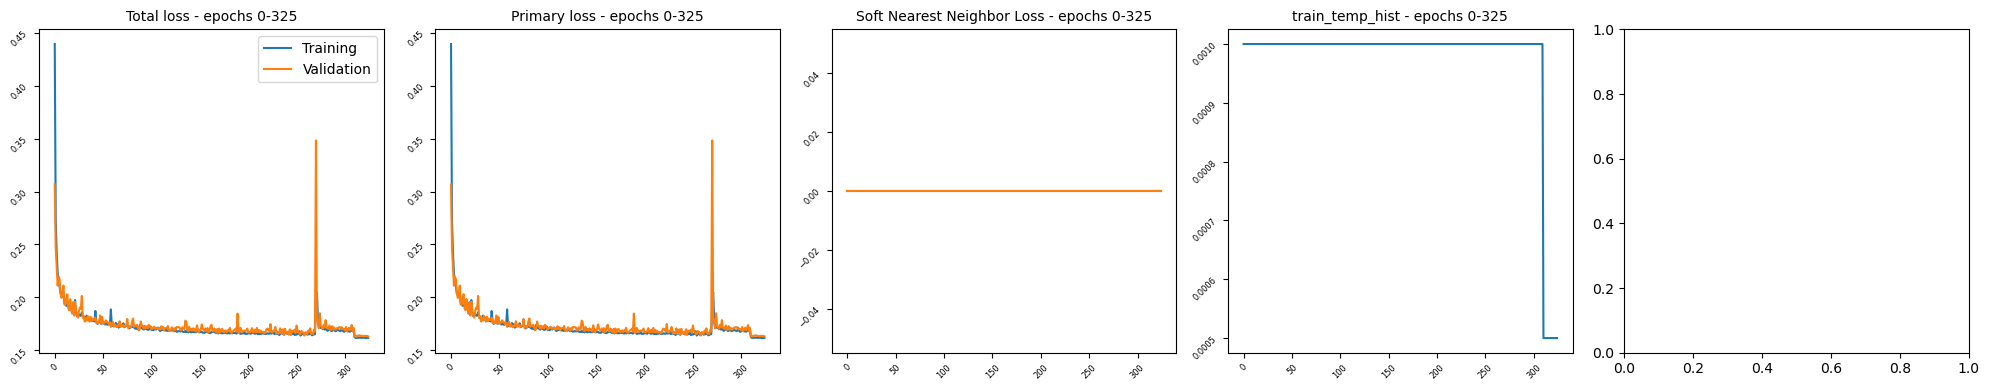

In [91]:
plot_train_history(model, start= 0, n_bins = 25)

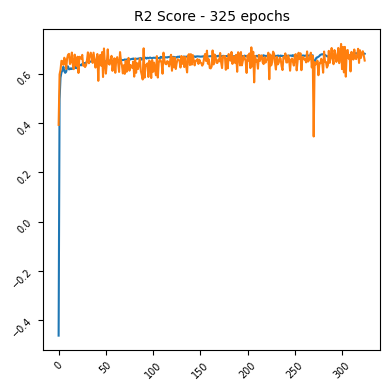

In [92]:
from snnl.utils import plot_regression_metrics
plot_regression_metrics(model, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

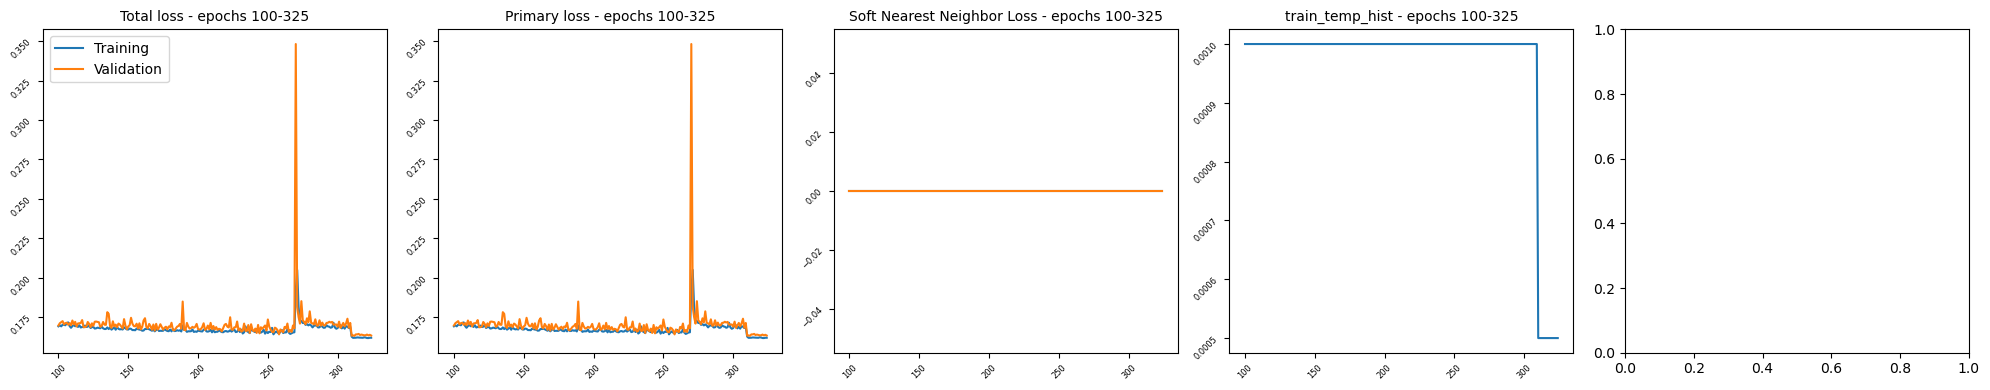

In [95]:
plot_train_history(model, start= 100, n_bins = 25)